## Literacy and fertility data

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


df = pd.read_csv('female_literacy_fertility.csv')
df.columns = df.columns.str.strip()


### EDA of literacy/fertility data

In [31]:
df.head()

,Country,Continent,female literacy,fertility,population
0,Chine,ASI,90.5,1.769,"1,324,655,000"
1,Inde,ASI,50.8,2.682,"1,139,964,932"
2,USA,NAM,99.0,2.077,"304,060,000"
3,Indonésie,ASI,88.8,2.132,"227,345,082"
4,Brésil,LAT,90.2,1.827,"191,971,506"


In [32]:
df.Continent.value_counts(dropna=False)

AF     49
ASI    47
EUR    36
LAT    24
OCE     4
NAM     2
Name: Continent, dtype: int64

In [33]:
df['Country'].value_counts(dropna=False).head()

Burundi                          1
Macao, Chine                     1
Liban                            1
Iran, République islamique d'    1
Ouzbékistan                      1
Name: Country, dtype: int64

In [34]:
df.iloc[0]

Country                    Chine
Continent                    ASI
female literacy             90.5
fertility                  1.769
population         1,324,655,000
Name: 0, dtype: object

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162 entries, 0 to 161
Data columns (total 5 columns):
Country            162 non-null object
Continent          162 non-null object
female literacy    162 non-null float64
fertility          162 non-null float64
population         162 non-null object
dtypes: float64(2), object(3)
memory usage: 6.4+ KB


In [36]:
df.population = df.population.str.replace(',', '').astype(float)

In [37]:
df.describe()

,female literacy,fertility,population
count,162.000000,162.000000,1.620000e+02
mean,80.107407,2.878673,4.068708e+07
std,23.052415,1.427597,1.409695e+08
min,12.600000,0.966000,1.035660e+05
25%,66.425000,1.823250,3.368292e+06
50%,90.000000,2.367500,9.707404e+06
75%,98.500000,3.880250,2.882991e+07
max,100.000000,7.069000,1.324655e+09


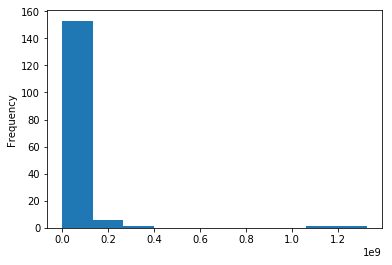

In [38]:
df.population.plot('hist')
plt.show()

In [39]:
df[df.population > 1000000000]

,Country,Continent,female literacy,fertility,population
0,Chine,ASI,90.5,1.769,1.324655e+09
1,Inde,ASI,50.8,2.682,1.139965e+09


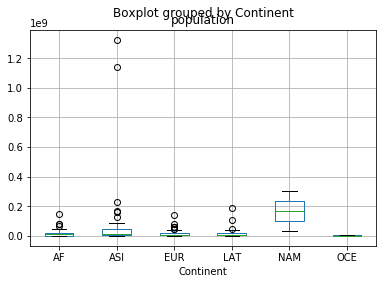

In [40]:
df.boxplot(column='population', by='Continent')
plt.show()

### Correlation between female literacy and fertility

we will look at the correlation between female literacy and fertility (defined as the average number of children born per woman) throughout the world. For ease of analysis and interpretation, we will work with the illiteracy rate.

It is always a good idea to do some EDA ahead of our analysis. To this end, we will plot the fertility versus illiteracy and compute the Pearson correlation coefficient. 

In [8]:
def pearson_r(x, y):
    """Compute Pearson correlation coefficient between two arrays."""
    # Compute correlation matrix: corr_mat
    corr_mat = np.corrcoef(x, y)

    # Return entry [0,1]
    return corr_mat[0,1]


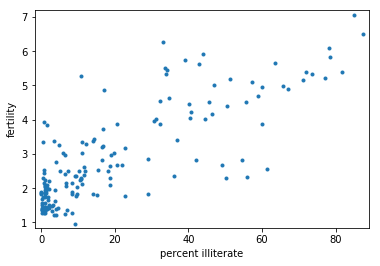

Pearson correlation coefficient: 0.804132402682


In [9]:
# Plot the illiteracy rate versus fertility
df['illiteracy'] = 100 - df['female literacy']

_ = plt.plot(df['illiteracy'], df['fertility'], marker='.', linestyle='none')

# Set the margins and label axes
plt.margins(0.02)
_ = plt.xlabel('percent illiterate')
_ = plt.ylabel('fertility')

# Show the plot
plt.show()

# Print the Pearson correlation coefficient
print("Pearson correlation coefficient:", pearson_r(df['illiteracy'], df['fertility']))


### Linear Regression

slope = 0.0497985480906 children per woman / percent illiterate
intercept = 1.88805061064 children per woman


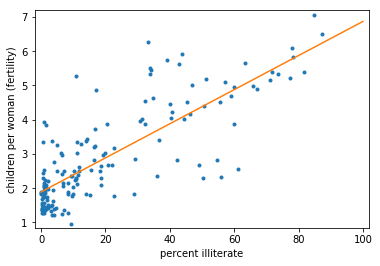

In [10]:
# Plot the illiteracy rate versus fertility
_ = plt.plot(df['illiteracy'], df['fertility'], marker='.', linestyle='none')
plt.margins(0.02)

# Perform a linear regression using np.polyfit(): a, b
a, b = np.polyfit(df['illiteracy'], df['fertility'], 1)

# Print the results to the screen
print('slope =', a, 'children per woman / percent illiterate')
print('intercept =', b, 'children per woman')

# Make theoretical line to plot
x = np.array([0, 100])
y = a * x + b

# Add regression line to your plot
_ = plt.plot(x, y)
_ = plt.xlabel('percent illiterate')
_ = plt.ylabel('children per woman (fertility)')

# Draw the plot
plt.show()


#### How is it optimal?

The function np.polyfit() that you used to get your regression parameters finds the optimal slope and intercept. It is optimizing the sum of the squares of the residuals, also known as RSS (for residual sum of squares). 

Now, we will plot the function that is being optimized, the RSS, versus the slope parameter a. To do this, we will fix the intercept to be what you found in the optimization. Then, plot the RSS vs. the slope. Where is it minimal?

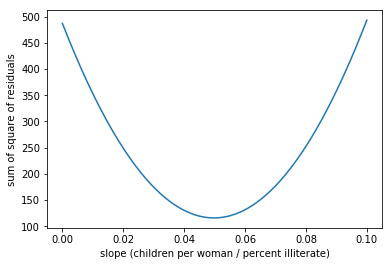

In [11]:
# Specify slopes to consider: a_vals
# linspace Return evenly spaced numbers over a specified interval (start, end, number of values)
a_vals = np.linspace(0, 0.1, 200)

# Initialize sum of square of residuals: rss
# empty_like Returns a new array with the same shape and type as a given array.
rss = np.empty_like(a_vals)

# Compute sum of square of residuals for each value of a_vals
for i, a in enumerate(a_vals):
    rss[i] = np.sum((df['fertility'] - a*df['illiteracy'] - b)**2)

    
# Plot the RSS
plt.plot(a_vals, rss, '-')
plt.xlabel('slope (children per woman / percent illiterate)')
plt.ylabel('sum of square of residuals')

plt.show()

Notice that the minimum on the plot, that is the value of the slope that gives the minimum sum of the square of the residuals, is the same value you got when performing the regression.

### Pairs bootstrap of literacy/fertility data
#### A function to do pairs bootstrap

In [12]:
def draw_bs_pairs_linreg(x, y, size=1):
    """Perform pairs bootstrap for linear regression."""

    # Set up array of indices to sample from: inds
    inds = np.arange(len(x))

    # Initialize replicates: bs_slope_reps, bs_intercept_reps
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x, bs_y, 1)
    return bs_slope_reps, bs_intercept_reps


Using the function you just wrote, perform pairs bootstrap to plot a histogram describing the estimate of the slope from the illiteracy/fertility data.

[ 0.04419351  0.05517262]


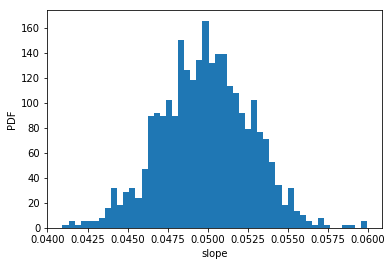

In [13]:
# Generate replicates of slope and intercept using pairs bootstrap
bs_slope_reps, bs_intercept_reps = draw_bs_pairs_linreg(df['illiteracy'], df['fertility'], 1000)

# Compute and print 95% CI for slope
print(np.percentile(bs_slope_reps, [2.5,  97.5]))


# Plot the histogram
_ = plt.hist(bs_slope_reps, bins=50, normed=True)
_ = plt.xlabel('slope')
_ = plt.ylabel('PDF')
plt.show()

#### Plotting bootstrap regressions

A nice way to visualize the variability we might expect in a linear regression is to plot the line you would get from each bootstrap replicate of the slope and intercept.

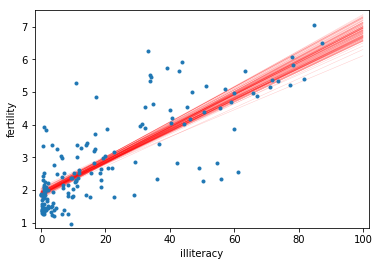

In [14]:
# Generate array of x-values for bootstrap lines: x
x = np.array([0, 100])

# Plot the bootstrap lines
for i in range(100):
    _ = plt.plot(x, bs_slope_reps[i]*x + bs_intercept_reps[i],
                 linewidth=0.5, alpha=0.2, color='red')

# Plot the data
_ = plt.plot(df['illiteracy'], df['fertility'], marker='.',  linestyle='none')

# Label axes, set the margins, and show the plot
_ = plt.xlabel('illiteracy')
_ = plt.ylabel('fertility')
plt.margins(0.02)
plt.show()

#### Hypothesis test on Pearson correlation

The observed correlation between female illiteracy and fertility may just be by chance; the fertility of a given country may actually be totally independent of its illiteracy. We will test this hypothesis. To do so, we will permute the illiteracy values but leave the fertility values fixed. This simulates the hypothesis that they are totally independent of each other. For each permutation, we compute the Pearson correlation coefficient and assess how many of your permutation replicates have a Pearson correlation coefficient greater than the observed one.

In [22]:
# Compute observed correlation: r_obs
r_obs = pearson_r(df['illiteracy'], df['fertility'])

# Initialize permutation replicates: perm_replicates
perm_replicates = np.empty(10000)


# Draw replicates
for i in range(10000):
    # Permute illiteracy measurments: illiteracy_permuted
    illiteracy_permuted = np.random.permutation(df['illiteracy'])

    # Compute Pearson correlation
    perm_replicates[i] = pearson_r(illiteracy_permuted, df['fertility'])

# Compute p-value: p
p = np.sum(perm_replicates  >= r_obs) / len(perm_replicates)
print('p-val =', p)



p-val = 0.0


You got a p-value of zero. In hacker statistics, this means that your p-value is very low, since you never got a single replicate in the 10,000 you took that had a Pearson correlation greater than the observed one. You could try increasing the number of replicates you take to continue to move the upper bound on your p-value lower and lower.